## Dataset generation using opencv

In [2]:
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import keras
import keras_metrics
import matplotlib.pyplot as plt
import os 
from random import shuffle
from tqdm import tqdm

In [ ]:
def dataset_generation():
    FaceClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    def face_detection(image):
        gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detected_face = FaceClassifier.detectMultiScale(gray_scale, 1.3, 5)
        
        if detected_face is ():
            return None
        for (x,y,w,h) in detected_face:
            face = image[y:y+h,x:x+w]
        return face
    
    videoCapture = cv2.VideoCapture(0)
    image_id = 0
    
    while True:
        ret, frame = videoCapture.read()
        if face_detection(frame) is not None:
            image_id+=1
            face = cv2.resize(face_detection(frame), (250,250))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            #Saving images from web cam to local disk
            file_name_path = "Dataset/"+"Yousaf_"+str(image_id)+'.jpg'
            cv2.imwrite(file_name_path, face)
            cv2.putText(face, str(image_id), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2 )
            
            cv2.imshow("Cropped_Face", face)
            if cv2.waitKey(1)==13 or int(image_id)==500:
                break
                
    videoCapture.release()
    cv2.destroyAllWindows()
    print("Data Collection is completed")

In [ ]:
dataset_generation()

In [3]:
import numpy as np

In [4]:
#Creating labels for each person
def label(image):
    name = image.split("_")[0]
    #One hot encoding for four persons 
    if name == "Yousaf":
        return 0
    elif name == "Qazi":
        return 1
    elif name == "Abdullah":
        return 2
    elif name == "Manzoor":
        return 3

## Preparing dataset for deep learning model

In [5]:
def load_data():
    dataset = []
    for image_name in tqdm(os.listdir("C:\\Users\\Marhaba\\Desktop\\Computer Vision\\FaceId_Door_Lock_System\\Dataset")):
        image_path = os.path.join("C:\\Users\\Marhaba\\Desktop\\Computer Vision\\FaceId_Door_Lock_System\\Dataset",image_name)
        image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        dataset.append([image,label(image_name)])
    shuffle(dataset)
    return dataset

In [6]:
dataset = load_data()

100%|██████████| 2000/2000 [00:02<00:00, 882.60it/s] 


In [7]:
dataset[10]

[array([[ 63,  62,  62, ..., 128, 128, 128],
        [ 63,  62,  61, ..., 128, 129, 129],
        [ 62,  62,  61, ..., 128, 128, 128],
        ...,
        [106, 106, 105, ..., 144, 144, 143],
        [106, 105, 105, ..., 151, 149, 148],
        [106, 105, 105, ..., 152, 151, 150]], dtype=uint8),
 2]

In [8]:
#Splitting dataset into training and testing 
train_dataset = dataset[:1600]
test_dataset = dataset[1600::]
X = np.array([k[0] for k in train_dataset]).reshape(-1,250,250,1)
print(X.shape)
Y = [j[1] for j in train_dataset]
Y = to_categorical(Y)
print(Y.shape)
X_test = np.array([k[0] for k in test_dataset]).reshape(-1,250,250,1)
print(X_test.shape)
Y_test = [j[1] for j in test_dataset]
Y_test = to_categorical(Y_test)
print(Y_test.shape)

(1600, 250, 250, 1)
(1600, 4)
(400, 250, 250, 1)
(400, 4)


## CNN architecture for face recognition

In [9]:
print(Y[0])

[0. 0. 1. 0.]


In [10]:
#CNN Architecture for face recognition
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(250,250,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        3904      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)     

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
history=model.fit(X, Y, epochs=10, batch_size=32, verbose=1, validation_split=0.3)

tracking <tf.Variable 'Variable:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_1:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_2:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_3:0' shape=() dtype=int32> fn
tracking <tf.Variable 'Variable_4:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_5:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_6:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_7:0' shape=() dtype=int32> fn

Train on 1120 samples, validate on 480 samples
Epoch 1/10
1120/1120 [==============================] - 92s 82ms/step - loss: 3.4897 - accuracy: 0.8696 - precision: 0.7406 - recall: 0.7396 - f1_score: 0.7393 - val_loss: 1279.9519 - val_accuracy: 0.2521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/10
1120/1120 [==============================] - 86s 76ms/step - loss: 2.4339 - accuracy: 0.9661 - precision: 0.9734 - recall: 0.9737 - f1_score: 0.9734 - val_loss: 5

In [13]:
model.evaluate(X_test,Y_test,verbose=1)

400/400 [==============================] - 5s 12ms/step


[14.30105297088623,
 0.9075000286102295,
 1.0,
 0.9506106972694397,
 0.9744839072227478]

In [14]:
history.history.keys()


dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'loss', 'accuracy', 'precision', 'recall', 'f1_score'])

dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'loss', 'accuracy', 'precision', 'recall', 'f1_score'])


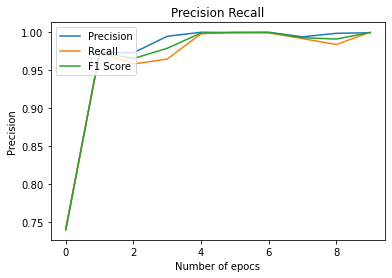

In [17]:
print(history.history.keys())
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['f1_score'])
plt.title('Precision Recall')
plt.ylabel('Precision')
plt.xlabel('Number of epocs')
plt.legend(['Precision', 'Recall','F1 Score'], loc='upper left')
plt.show()

In [27]:
model.save('Saved_Model.h5')


In [31]:
# saving and loading the model weights
 
# save model
model.save_weights('gfgModelWeights')
print('Model Saved!')
 
# load model
savedModel = model.load_weights('gfgModelWeights')
print('Model Loaded!')

Model Saved!
Model Loaded!


In [35]:
#CNN Architecture for face recognition
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(250,250,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 60, 60, 32)        3904      
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)      

In [36]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
# load model
savedModel = model2.load_weights('gfgModelWeights')
print('Model Loaded!')

tracking <tf.Variable 'Variable_8:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_9:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_10:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_11:0' shape=() dtype=int32> fn
tracking <tf.Variable 'Variable_12:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_13:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_14:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_15:0' shape=() dtype=int32> fn
Model Loaded!


In [37]:
model2.evaluate(X_test,Y_test,verbose=1)

400/400 [==============================] - 3s 8ms/sample - loss: 14.3011 - acc: 0.9075 - precision: 1.0000 - recall: 0.9757 - f1_score: 0.9872


[14.30105297088623, 0.9075, 1.0, 0.9756993, 0.98716015]